In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib  # for saving model


In [7]:
# Load the dataset - 'spam.csv' should be in your working directory
df = pd.read_csv('spam.csv', encoding='latin-1')

# Keep only relevant columns
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Function to clean text
def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.strip()
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muzam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [10]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
df[['label', 'label_num']].head()


,label,label_num
0,ham,0
1,ham,0
2,spam,1
3,ham,0
4,ham,0


In [11]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['label_num']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [13]:
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

Accuracy Score: 0.9775784753363229

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



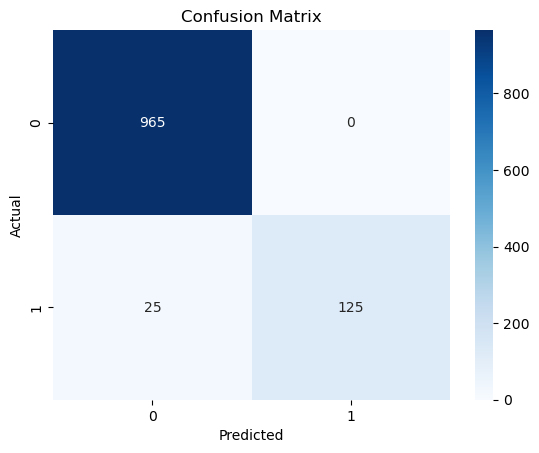

In [14]:
y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:
joblib.dump(model, 'spam_classifier_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [16]:
def predict_spam(message):
    # Load model and vectorizer
    model = joblib.load('spam_classifier_model.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    
    # Clean message
    cleaned = clean_text(message)
    vector = vectorizer.transform([cleaned])
    
    # Predict
    result = model.predict(vector)[0]
    return "Spam ❌" if result == 1 else "Not Spam ✅"

# Try it
predict_spam("Congratulations! You won a free iPhone!")


'Spam ❌'

In [27]:
import gradio as gr
import pandas as pd
import joblib
import re
import string

# Load saved model and vectorizer
model = joblib.load("spam_classifier_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")


In [29]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [31]:
def predict_spam(message):
    cleaned = clean_text(message)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    confidence = model.predict_proba(vector).max()
    
    if prediction == 1:
        return f"❌ **Spam**\nThis looks like a spam message.\n⚠️ Confidence: {confidence:.2f}"
    else:
        return f"✅ **Not Spam**\nThis message seems safe.\n🟢 Confidence: {confidence:.2f}"


In [33]:
examples = [
    "Congratulations! You’ve won a free cruise trip. Call now!",
    "Hey, are we still meeting tomorrow at 5?",
    "URGENT! Verify your account immediately to avoid deactivation.",
    "Can you send me the notes from today's lecture?",
    "You have been selected for a cash prize. Claim now!"
]

gr.Interface(
    fn=predict_spam,
    inputs=gr.Textbox(lines=4, placeholder="Enter your message here...", label="📩 Message Input"),
    outputs=gr.Markdown(label="🔍 Result"),
    examples=examples,
    title="📬 Spam Email Detector",
    description="🔐 This tool predicts whether a message is Spam or Not using a Naive Bayes model trained on SMS data."
).launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [67]:
## Import required libraries
import gradio as gr
import pandas as pd
import joblib
import re
import string

## Load pre-trained model and TF-IDF vectorizer
model = joblib.load("spam_classifier_model.pkl")            ## Trained spam classifier (e.g., Naive Bayes)
vectorizer = joblib.load("tfidf_vectorizer.pkl")            ## TF-IDF vectorizer used during training

## Function to clean the input text
def clean_text(text):
    text = text.lower()                                     ## Convert to lowercase
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  ## Remove punctuation
    text = re.sub(r'\d+', '', text)                         ## Remove digits
    text = re.sub(r'\s+', ' ', text).strip()                ## Normalize whitespace
    return text

## Function to predict whether a message is spam or not
def predict_spam(message):
    cleaned = clean_text(message)                           ## Clean the message
    vector = vectorizer.transform([cleaned])                ## Vectorize using TF-IDF
    prediction = model.predict(vector)[0]                   ## Predict label (0 = not spam, 1 = spam)
    confidence = model.predict_proba(vector).max()          ## Get confidence score

    ## Format result with confidence
    if prediction == 1:
        return f"❌ **Spam**\nThis looks like a spam message.\n⚠️ Confidence: {confidence:.2f}"
    else:
        return f"✅ **Not Spam**\nThis message seems safe.\n🟢 Confidence: {confidence:.2f}"

## Custom CSS to apply light blue theme with white text
custom_css = """
body, .gradio-container {
    background-color: #add8e6 !important;   /* Light Blue */
    color: #ffffff !important;              /* White text */
    font-family: 'Segoe UI', sans-serif;
}

input, textarea, .input-textbox {
    background-color: #87cefa !important;   /* Light Sky Blue */
    color: #ffffff !important;
    border: 1px solid #ffffff !important;
}

.output-markdown {
    background-color: #87cefa !important;
    border: 1px solid #ffffff !important;
    color: #ffffff !important;
}

button {
    background-color: #ffffff !important;
    color: #1e3a5f !important;
    border: none !important;
    font-weight: bold !important;
}

button:hover {
    background-color: #f0f0f0 !important;
    cursor: pointer;
}

h1, h2, .title, .description {
    color: #ffffff !important;
}
"""

## Example messages to show use cases
examples = [
    "Congratulations! You’ve won a free cruise trip. Call now!",
    "Hey, are we still meeting tomorrow at 5?",
    "URGENT! Verify your account immediately to avoid deactivation.",
    "Can you send me the notes from today's lecture?",
    "You have been selected for a cash prize. Claim now!"
]

## Gradio interface setup
gr.Interface(
    fn=predict_spam,
    inputs=gr.Textbox(lines=4, placeholder="Enter your message here...", label="📩 Message Input"),
    outputs=gr.Markdown(label="🔍 Result"),
    examples=examples,
    title="📬 Spam Email Detector",
    description="🔐 A smart Naive Bayes model trained on SMS data to detect spam messages.",
    css=custom_css
).launch()


* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.
